# Predicting Heart Disease Using Classification
#### Group 11: Cameron Geisler, Daisy Liu, Nima Zareian, Sean Chung
## Introduction
This project will use [Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease), which describes the various attributes, symptoms and observations seen on patients in the process of being diagnosed with cardiovascular diseases. 
<br> <br>
Specifically, the project will be using a [processed version](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data) of said data containing information documented by the Cleveland Foundation, which is the most complete out of all given options.
<br> <br>
Diagnosis for cardiovascular diseases are often based on direct examinations of the heart done through the use of electrocardiograms (measures heart beat rhythms) and echocardiograms (measures the heart's physical state with ultrasound).
<br> <br>
Aside from these direct testing methods, there are other health metrics which can be used to help predict heart disease. Incidentally, almost half of all heart attacks experienced by people were unanticipated due to the presence of asymptomatic heart diseases, that is, heart diseases with little to no experience based indicators, and are thus difficult to notice and diagnose.

<b>Predictive question:</b> Given easily measured health indicators, such as age and maximum heart rate, what is the status of patients' heart disease (present/absent)?
<br>

## Methods

First, we load the necessary packages.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(tidymodels)))
suppressWarnings(suppressMessages(library(repr)))
suppressWarnings(suppressMessages(library(GGally)))
options(repr.matrix.max.rows = 6)

Next, we load the dataset from the [URL](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data).

In [2]:
# Load the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
data_raw <- read_csv(url, col_names = names)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



The data is already in a tidy format. However, we will make some small changes such as making the column names more descriptive and human readable, and converting the columns to the correct data type. In this analysis we will use the variables: age (years) and maximum heart rate (bpm) to predict the presence of heart disease in a patient. Also, in the original data, there are five levels of heart disease (labelled 0, 1, 2, 3, 4), which indicate varying degrees of disease, from "no visible heart disease" to "very severe heart disease". We combine levels 1-4, in order to simply classify the observations as having heart disease (labelled as "Yes") or not (labelled as "No").

In [3]:
# Wrangle data
heart_data <- data_raw %>%
    select(c("age", "thalach", "num")) %>% # select only columns that are used
    mutate(num = as_factor(num)) %>% # update target variables to factor
    rename(heart_disease = num, # rename columns with more intuitive names
          max_heart_rate = thalach) %>%
    mutate(heart_disease = factor(ifelse(heart_disease == 0, "No", "Yes"), levels = c("Yes", "No")))
    # change heart_disease from 0 and 1 to No and Yes, also reorder levels so in upcoming visualizations, Yes is red and No is blue
head(heart_data)

age,max_heart_rate,heart_disease
<dbl>,<dbl>,<fct>
63,150,No
67,108,Yes
67,129,Yes
37,187,No
41,172,No
56,178,No


Table 1: Sample observations from the dataset.

Here, we split the data into training and testing set. The training set will be used to train the K-nearest neighbors model, and the final model's accuracy will be measured by applying it to the testing set. We use a $75/25$ split, because we want the training set to be as large as possible to create an accurate model, but also so that the testing set is large enough to have a balance of observations with and without heart disease.

In [4]:
set.seed(1) # set the seed

heart_split = initial_split(heart_data, prop = 0.75, strata = heart_disease)
heart_training = training(heart_split)
heart_testing = testing(heart_split)

Table 2 and Figure 1 display the proportion of individuals in the training set that have and do not have heart disease. These proportions are roughly equal, being approximately $55/45$. In particular, the proportions are not very different, so it is not necessary to balance the data set before performing K-nearest neighbors.

In [19]:
# Training dataset summary
heart_training %>%
    group_by(heart_disease) %>%
    summarize(n = n(), .groups = "drop") %>%
    mutate(percent = n / nrow(heart_training))

heart_disease,n,percent
<fct>,<int>,<dbl>
Yes,105,0.4605263
No,123,0.5394737


Table 2: Summary of the training dataset based on presence of heart disease

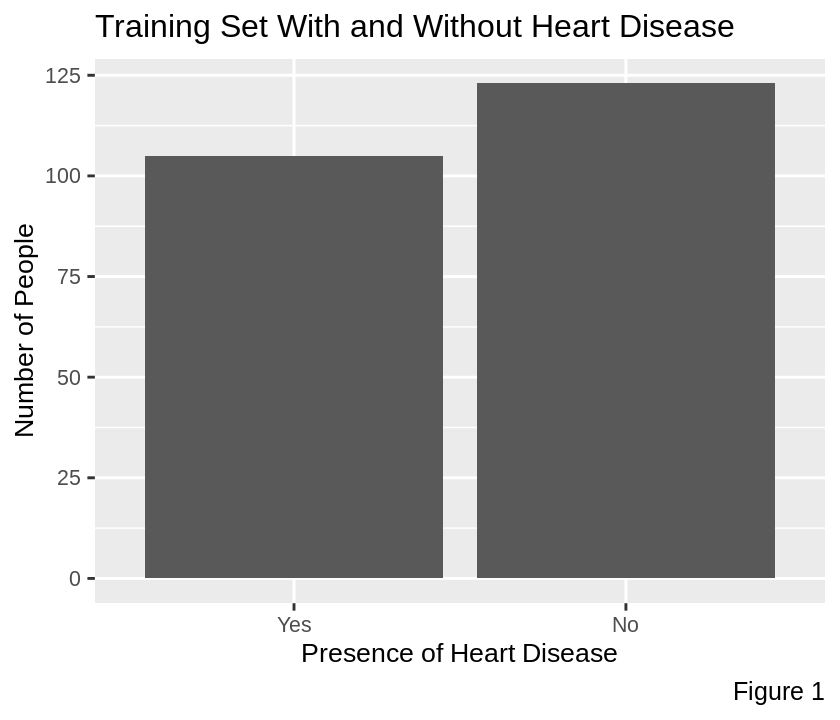

In [20]:
options(repr.plot.width = 7, repr.plot.height = 6)
ggplot(heart_training, aes(x = heart_disease)) +
    geom_bar() +
    xlab("Presence of Heart Disease") +
    ylab("Number of People") +
    ggtitle("Training Set With and Without Heart Disease") + 
    labs(caption = "Figure 1") +
    theme(text = element_text(size = 16),
          plot.caption = element_text(size = 15))

Figure 2 is a histogram that shows the distribution of age, by the presence of heart disease (red for Yes, blue for No). Similarly, figure 3 shows the distribution of max heart rate, by the presence of heart disease. Looking at the histograms, it seems that age is positively associated with heart disease (older people are more likely to have heart disease), and maximum heart rate is negatively associated with heart disease (people with lower max heart rate are more likely to have heart disease).

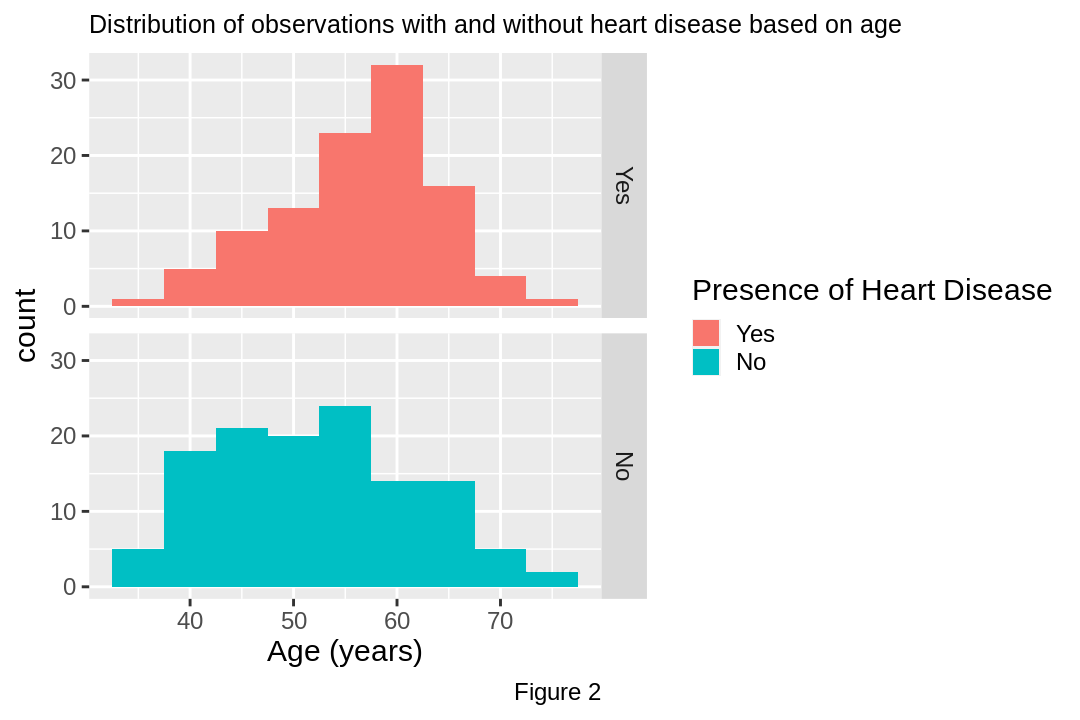

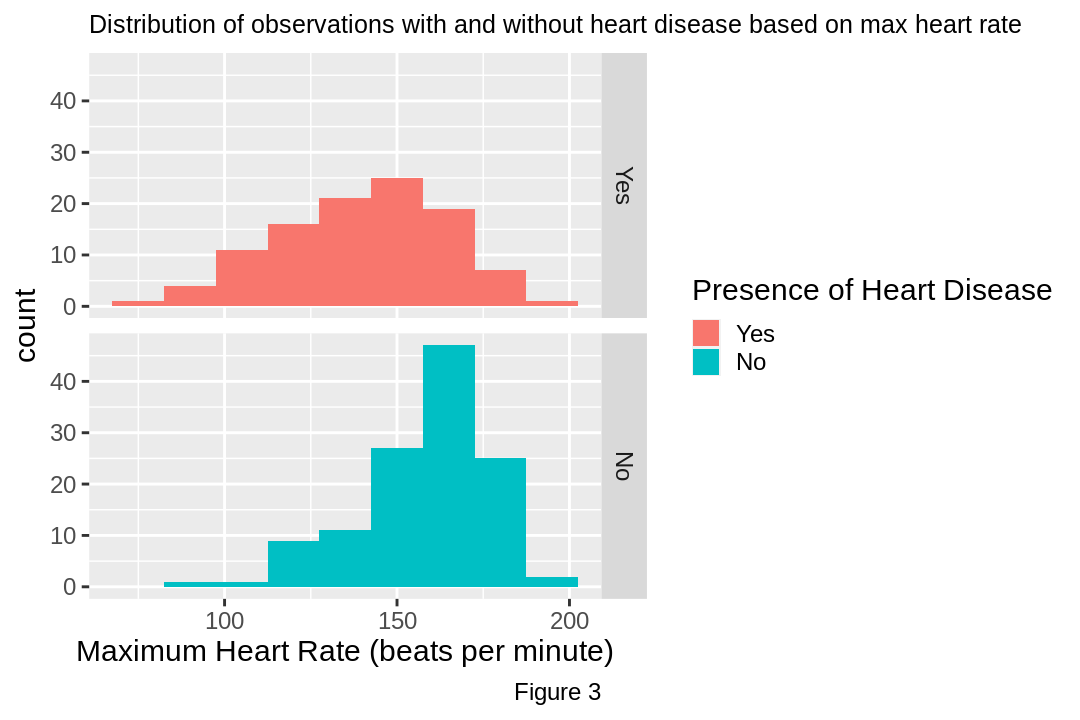

In [46]:
# Histograms for predictor variables
options(repr.plot.width = 9, repr.plot.height = 6)
theme_set(theme_gray(base_size = 18))

ggplot(heart_training, aes(x = age, fill = heart_disease)) +
    geom_histogram(binwidth = 5) +
    facet_grid(rows = heart_training$heart_disease) + 
    labs(x = "Age (years)", fill = "Presence of Heart Disease", caption = "Figure 2") +
    ggtitle("Distribution of observations with and without heart disease based on age") +
    theme(plot.title = element_text(size = 15))

ggplot(heart_training, aes(x = max_heart_rate, fill = heart_disease)) +
    geom_histogram(binwidth = 15) +
    facet_grid(rows = heart_training$heart_disease) + 
    labs(x = "Maximum Heart Rate (beats per minute)", fill = "Presence of Heart Disease", caption = "Figure 3") +
    ggtitle("Distribution of observations with and without heart disease based on max heart rate") +
    theme(plot.title = element_text(size = 15))

Figure 4 is a scatterplot, which combines the two variables, and the points are again colored using the presence of heart disease. Looking at the scatterplot, the observations with heart disease (red points) are clustered more towards the bottom half, and the observations without heart disease (blue points) are clustered more towards the top-left corner. The distinctions between presense of heart disease shown in Figures 2-4 show that both our predictors have some association with presence of heart disease.

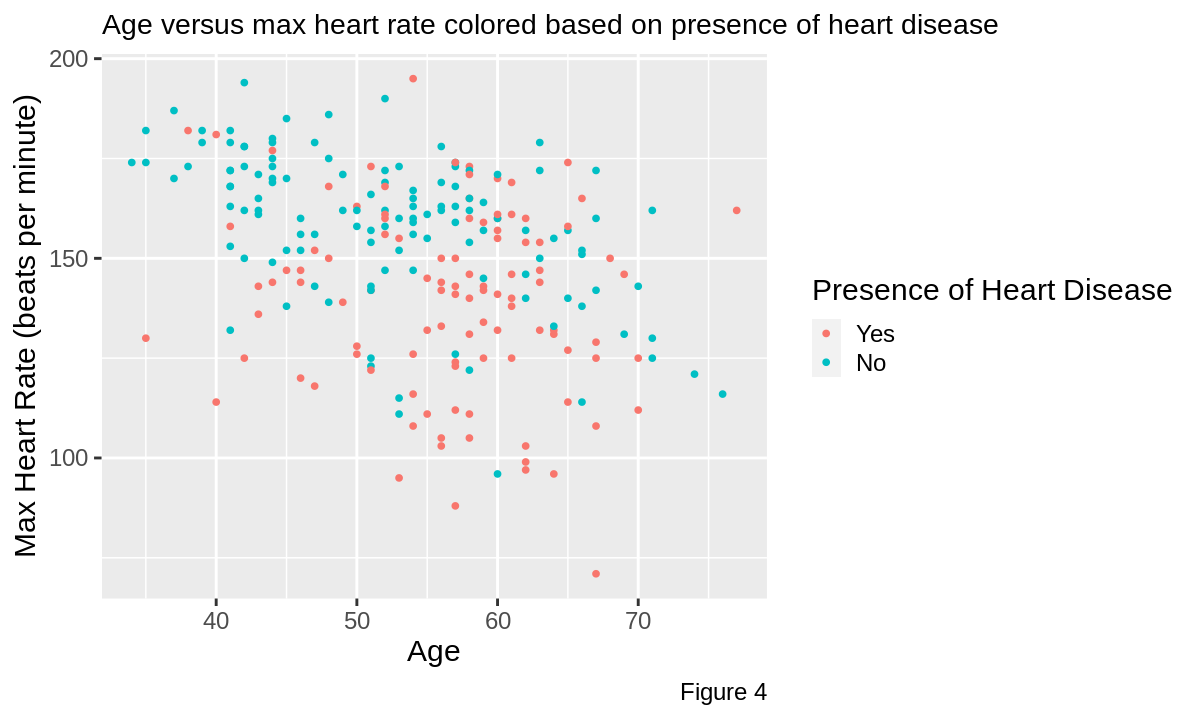

In [50]:
# Scatterplot
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(heart_training, aes(x = age, y = max_heart_rate, color = heart_disease)) + 
    geom_point() + 
    labs(x = "Age", y = "Max Heart Rate (beats per minute)", color = "Presence of Heart Disease", caption = "Figure 4") +  
    ggtitle("Age versus max heart rate colored based on presence of heart disease") +
    theme(plot.title = element_text(size = 17))

## K-NN Data Analysis

We use K-nearest neighbors classification, with predictor variables of age and maximum heart rate, and target variable of the diagnosis of heart disease. Using the training set, we further split the data set to perform cross-validation, and tune the value of $K$ to find the optimal value with maximum accuracy.

In [8]:
# Create a K-Nearest neighbor model for the training set
recipe <- recipe(heart_disease ~ age + max_heart_rate, data = heart_training) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
         set_engine("kknn") %>%
         set_mode("classification")

In [9]:
# Tune to find K with max accuracy
vfold <- vfold_cv(heart_training, v = 5, strata = heart_disease)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_result <- workflow() %>% 
          add_recipe(recipe) %>%
          add_model(spec) %>%
          tune_grid(resamples = vfold, grid = k_vals) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy")

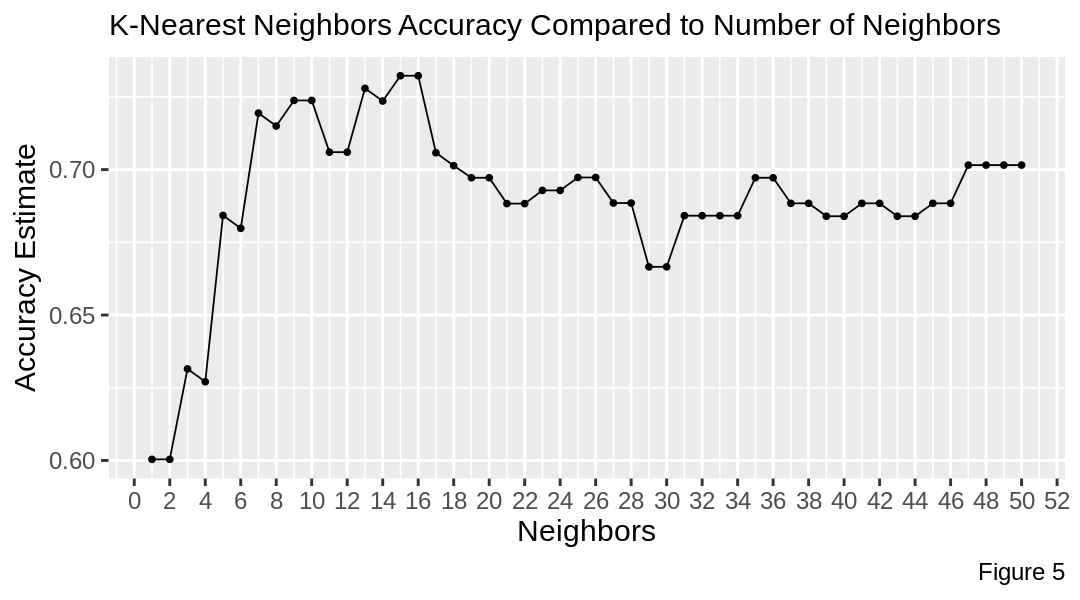

In [55]:
# Accuracy vs. K plot
options(repr.plot.width = 9, repr.plot.height = 5)

accuracy_vs_k <- ggplot(knn_result, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() + 
    labs(x = "Neighbors", y = "Accuracy Estimate", caption = "Figure 5") +   
    ggtitle("K-Nearest Neighbors Accuracy Compared to Number of Neighbors") +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 20)) +
    theme(plot.title = element_text(size = 18))
accuracy_vs_k

Here, we find the maximum estimated accuracy is with $k = 15$. Looking at the above graph, the estimated accuracy does not change drastically with neighboring values near $k = 15$, so this is a good choice.

In [11]:
max_accuracy <- knn_result %>%
  filter(mean == max(mean))
max_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.7322705,5,0.04272793,Model15
16,accuracy,binary,0.7322705,5,0.04272793,Model16


Table 3: Number of neighbors which resulted in the maximum accuracy (`mean`) in our cross validation of the training set

In [37]:
# Train model with actual K
k_max <- 15
actual_spec <- nearest_neighbor(weight_func = "rectangular", 
                                    neighbors = k_max) %>%
                                    set_engine("kknn") %>%
                                    set_mode("classification")

knn_fit <- workflow() %>%
       add_recipe(recipe) %>%  
       add_model(actual_spec) %>% 
       fit(data = heart_training)

# Results

Here, we use the model to make predictions on the testing set. The prediction accuracy (the proportion of correct predictions) is about 73%.

In [38]:
# Predictions and accuracy
predictions <- predict(knn_fit, heart_testing) %>% 
               bind_cols(heart_testing)

accuracy <- predictions %>%
            metrics(truth = heart_disease, estimate = .pred_class) %>%
            filter(.metric == "accuracy") %>%
            select(.estimate) %>%
            pull()
accuracy

[1] 0.7333333

Next, we create a confusion matrix. Notice that the false positive rate is $11/41 \approx 27\%$, and the false negative rate is $9/34 \approx 26\%$.

In [39]:
# Confusion matrix for predictions
conf_mat <- predictions %>%
    conf_mat(truth = heart_disease, estimate = .pred_class)
conf_mat

          Truth
Prediction Yes No
       Yes  25 11
       No    9 30

Table 4: Confusion matrix from model predicting presence of heat disease on the testing set

Finally, we can make a predictions plot (Figure 6), to see any general trends in the model.

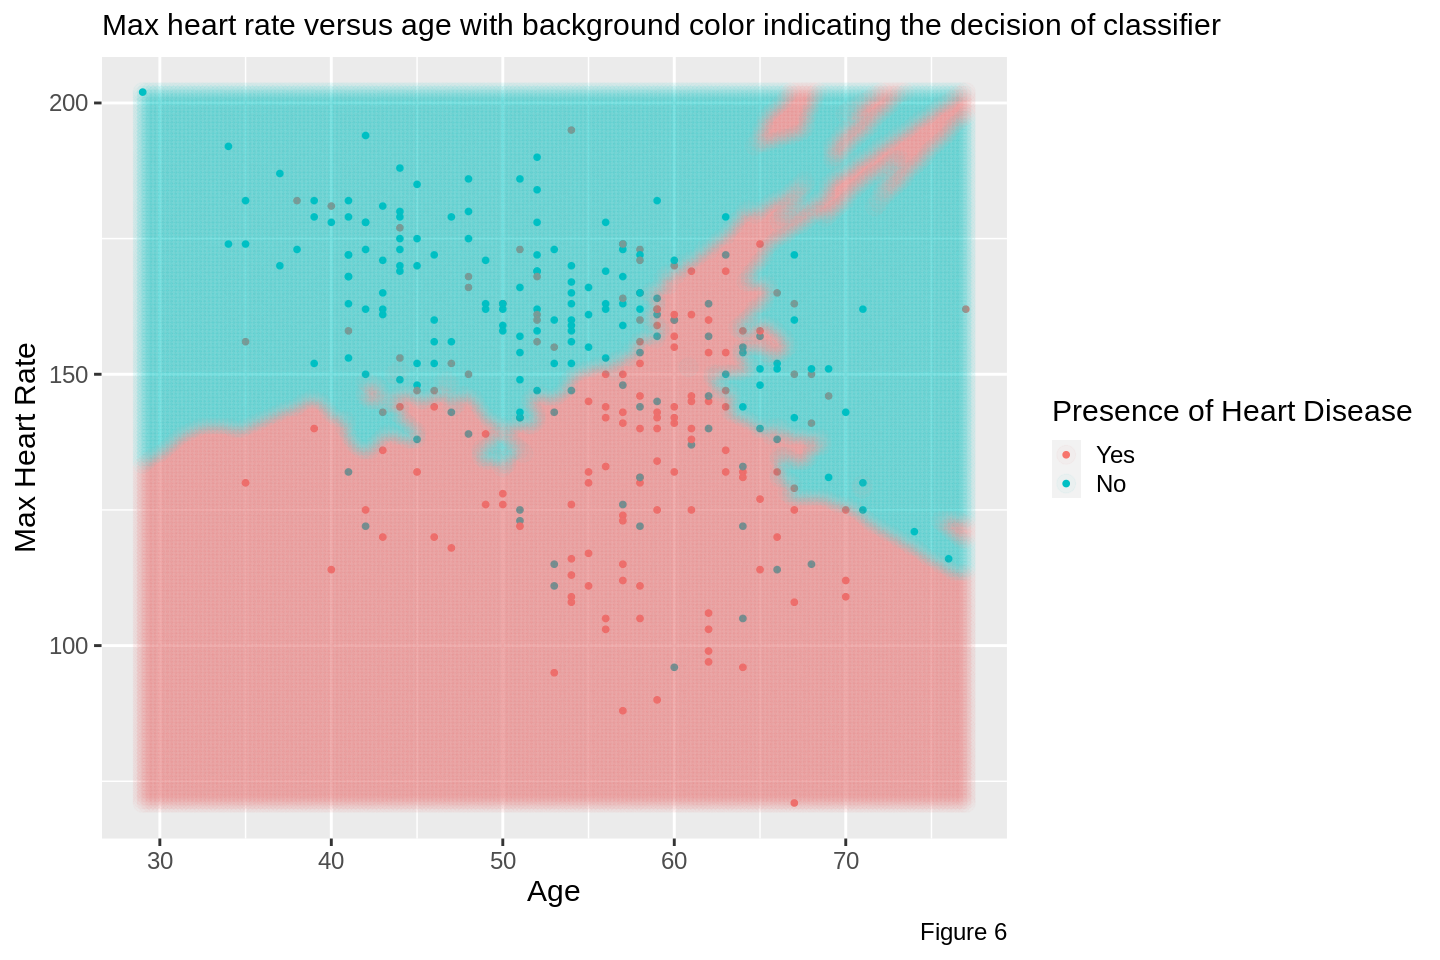

In [57]:
# Prediction results scatterplot
x_grid <- seq(min(heart_data$age), max(heart_data$age), length.out = 200)
y_grid <- seq(min(heart_data$max_heart_rate), max(heart_data$max_heart_rate), length.out = 200)
xy_grid <- as_tibble(expand.grid(age = x_grid, max_heart_rate = y_grid))
knn_pred_grid <- predict(knn_fit, xy_grid)
prediction_table <- bind_cols(knn_pred_grid, xy_grid)
options(repr.plot.width = 12, repr.plot.height = 8)

pred_plot <- ggplot() +
    geom_point(data = heart_data, mapping = aes(x = age, y = max_heart_rate, color = heart_disease), alpha = 1.5) +
    geom_point(data = prediction_table, mapping = aes(x = age, y = max_heart_rate, color = .pred_class), alpha = 0.03, size = 5) +
    labs(color = "Presence of Heart Disease", x = "Age", y = "Max Heart Rate", caption = "Figure 6") +
    ggtitle("Max heart rate versus age with background color indicating the decision of classifier") +
    theme(plot.title = element_text(size = 18))
pred_plot

## Discussion

#### Expected outcomes
* <b> Age </b> - Heart diseases are expected to be more common in older people (>65 years) since aging causes changes in the heart and blood vessels. Additionally, in Figure 2 there is a higher mean and median age of patients with heart disease than patients without heart disease.
* <b>Maximum heart rate</b> - We expect an association between a high maximum heart rate and heart disease since rapid heartbeat is a symptom of coronary artery disease. Surprisingly, Figure 3 visualizes a lower mean and median maximum heart rate for patients with heart disease compared to patients without. This variable shows unexpected results but may be a useful predictor as there is a significant difference between heart disease positive and negative patients using this predictor.
<br>
<!-- 2. <b>Resting blood pressure</b> - we expect that high blood pressure (>130mm assumed systolic bp) will be positively associated with presence of heart disease since high blood pressure is a risk factor for heart disease. However, the histogram above visualizes only a slightly higher mean and median blood pressure for patients with heart disease compared to patients who do not, indicating that resting blood pressure may not be as valuable a predictor as other variables.3. <b>Cholesterol</b> - we expect that high levels of cholesterol (>240mg/dL) will be positively associated with presence of heart disease since high cholesterol is known to increase risk of heart attacks. However, the histogram above visualizes only slightly higher mean cholesterol levels in patients with heart disease compared to patients without, indicating that resting blood pressure may not be as valuable a predictor as other variables. -->


#### Findings
Using the ggpairs function to compare the differences between patients with heart disease and patients without heart disease in all numerical variables, we discovered that maximum heart rate and age had the most significant gap between values associated with a presence of heart disease and values associated with an absence of heart disease. To optimize our model's accuracy, we reduced the amount of predictor variables in our predictive question which used to include four predictor variables (age, max heart rate, cholesterol and blood sugar level) to only include age and maximum heart rate as the predictors. Mapping the predicted present and absent heart disease cases using our selected predictors, we find that patients aged 30-60 with a maximum heart rate of less than about 150 BPM are predicted to have heart disease. On the other hand, in ages 65-75, the threshold for heart disease becomes lower as those with a maximum heart rate of under 120 BPM are predicted to have heart disease. 
The presence of heart disease correlated with lower maximum heart rate matched our expectations reasoned from Figure 3. The highest density of positive heart disease cases seem to be centered around age 55-65 years and decrease in density below and above those ages. This observation approximately matches our expectations that heart disease would be more common in older people.
Expectations aside, the accuracy of the model was about 73%. The data set has a proportion of about 55% No observations and 45% Yes observations, so a majority baseline model that always picks "No" would have an accuracy of about 55%. In this way, an improvement to 73% is significant. However, our model still contains a relatively high margin of error. If this model were to be used practically it should only advise patients whether they are likely to have heart disease based on their age and maximum heart rate as it is not accurate enough to make a reliable diagnosis.
<br><br>
<b>What impact could such findings have?</b> <br>
Predictions made by the indicators age and maximum heart rate can greatly reduce the chance of asymptomatic heart diseases going undiagnosed as these indicators are more conveniently measured than direct, elaborate testings on the heart which are usually only considered after the patient has experienced discomfort.
<br><br>
<b>What future questions could this lead to?</b><br>
This analysis exposed many interesting questions about the impact different health indicators have on heart disease. The predicted presence of heart disease in Figure 6 shows some unique features that defy logical surface expectations. For example, from age 60-65 presence of heart disease increases along the range of maximum heart rate values then decreases past the age of 65. What is the reason for this fall off when people older than 65 continue to weaken? Additionally, our analysis indicates that lower maximum heart rate correlate with a larger presence of heart disease. Why does lower maximum heart rate correlate with heart disease when rapid heart rate is a symptom? Future analyses may provide explanations as to why some of these relationships exist.
<!-- Which of these predictors has the highest impact on the presence of heart disease?
Do some of these predictors facilitate asymptomatic heart disease more than symptomatic ones? -->

## Bibliography
Andras Janosi, M.D., William Steinbrunn,.M.D., Matthias Pfisterer,.M.D., & Robert Detrano, .M.D, Ph.D. (1988, July 1). UCI Machine Learning Repository: Heart Disease Data Set [Dataset]. https://archive.ics.uci.edu/ml/datasets/heart+disease
<br><br>
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science
<br><br>
“Heart Health and Aging.” National Institute on Aging, U.S. Department of Health and Human Services, 1 June 2018, https://www.nia.nih.gov/health/heart-health-and-aging.
<br><br>
Perret-Guillaume C, Joly L, Benetos A. Heart rate as a risk factor for cardiovascular disease. Prog Cardiovasc Dis. 2009 Jul-Aug;52(1):6-10. doi: 10.1016/j.pcad.2009.05.003. PMID: 19615487.
<br><br>
“Prevention of Heart Diseases and Conditions.” Canada.ca, Public Health Agency of Canada, 10 Mar. 2017, https://www.canada.ca/en/public-health/services/diseases/heart-health/heart-diseases-conditions/prevention-heart-diseases-conditions.html.